In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime 
import math
import sys
sys.path.append('../')
#
from structures.ratecurves import *
from instruments.simpleswap import *
from models.hullwhitesimple import *
from engines.gaussian1d import *



## Simple swap price and rate sensy

In [2]:
rc_pillars = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
rc_rates = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
rate_curve = RateCurveSimple(rc_pillars, rc_rates)
## swap
irs_schedule = ['2024-10-11', '2025-10-11', '2026-10-11', '2027-10-11', '2028-10-11', '2029-10-11']
irs_schedule = [datetime.strptime(date, '%Y-%m-%d') for date in irs_schedule]
irs = SwapSimple(100000.0, 0.04, False, irs_schedule) #receiver

with tf.GradientTape() as tape:
    pv = irs.price(datetime.today(), rate_curve)
    
sensy_zero = tape.gradient(pv, rate_curve.rates)

## Hull and White simulation

In [3]:
mean_rev = 0.02
sigma = 0.045
hw = HullWhiteProcess(mean_rev, sigma, market_curve=rate_curve)


last_grid_time = 20
time_steps = 50
hw_kernel = GaussianRateKernel1D(hw)
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(1000, last_grid_time, time_steps)

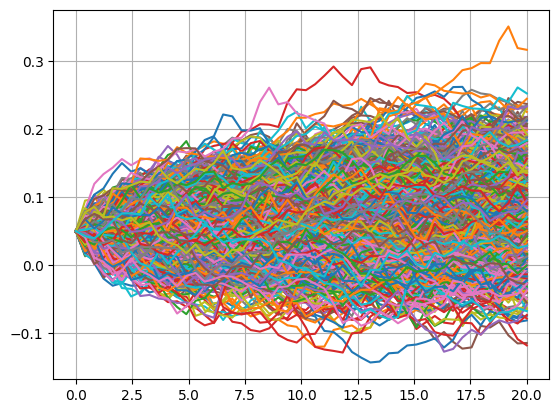

In [4]:
plt.plot(grid, r_tensor)
plt.grid()
plt.show()

## Test Pricing CPU

In [5]:
# Reshape the tensor
reshaped_tensor = tf.transpose(zb_tensor, perm=[1, 2, 0])  # Transpose the dimensions
reshaped_tensor = tf.reshape(reshaped_tensor, shape=(8, 1000, 49))
rate_curve_tensor = RateCurveSimple(rc_pillars, reshaped_tensor)

In [18]:
rc_pillars

[0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]

In [6]:
def portfolio_cube_std(portfolio):
    return [deal.price(datetime.today(), rate_curve_tensor) for deal in portfolio]

@tf.function
def portfolio_cube(portfolio):
    return [deal.price(datetime.today(), rate_curve_tensor) for deal in portfolio]

@tf.function(jit_compile = True)
def portfolio_cube_xla(portfolio):
    return [deal.price(datetime.today(), rate_curve_tensor) for deal in portfolio]


In [7]:
irs_schedule = ['2024-10-11', '2025-10-11', '2026-10-11', '2027-10-11', '2028-10-11', '2029-10-11']
irs_schedule = [datetime.strptime(date, '%Y-%m-%d') for date in irs_schedule]
irs = SwapSimple(100000.0, 0.04, False, irs_schedule) #receiver
irs_list = [irs]*1000

In [16]:
rate_curve_tensor

In [9]:
cube0 = portfolio_cube_std(irs_list)

In [10]:
cube0[0]

<tf.Tensor: shape=(1000, 49), dtype=float64, numpy=
array([[-46080.44664154, -45987.51475905, -45742.82030106, ...,
        -45907.55093082, -45843.11297604, -45750.32476328],
       [-46018.67463467, -45786.86348874, -45943.54816481, ...,
        -45536.99217181, -44828.84149368, -44863.72324667],
       [-45891.88337302, -45537.82734606, -45521.44196828, ...,
        -42354.60247816, -41810.371007  , -41670.12027392],
       ...,
       [-45999.86788201, -46056.91124931, -46053.17267327, ...,
        -45841.43149535, -45888.57171791, -45904.80445556],
       [-45417.13138009, -45159.91794465, -45572.7009553 , ...,
        -40662.60955601, -42183.38890035, -40801.45107088],
       [-46015.38337272, -46028.55606246, -45915.93342999, ...,
        -45825.60650598, -45892.13813977, -45876.69537924]])>